In [80]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


## DataSet

Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

(200, 2) (200, 1)


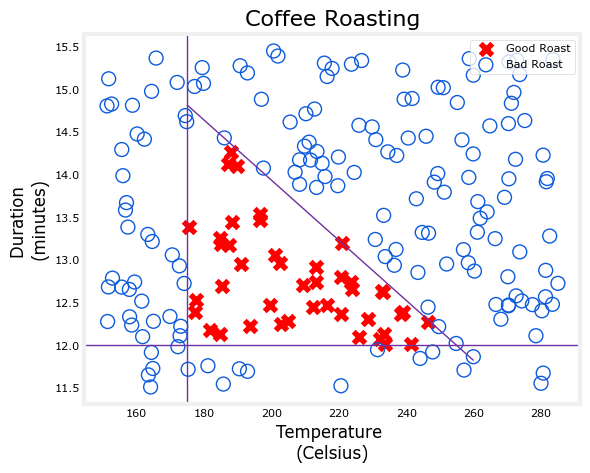

In [81]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

plt_roast(X,Y)

# print(X)
# print(X[:,0])
# print(X[0,:])

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [82]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

# create a normalization layer
normalization_layer = tf.keras.layers.Normalization(axis=-1)
# The axis=-1 argument specifies that the normalization should be applied to the last axis of the input. 
# In a 2D array, this would be the columns.

normalization_layer.adapt(X)  # learns mean, variance
X_normalized = normalization_layer(X)
print(X_normalized)

print(f"Temperature Max, Min post normalization: {np.max(X_normalized[:,0]):0.2f}, {np.min(X_normalized[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(X_normalized[:,1]):0.2f}, {np.min(X_normalized[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
tf.Tensor(
[[-0.83 -0.65]
 [ 1.03 -1.39]
 [ 0.31  0.87]
 [-1.08 -1.52]
 [-0.79  0.62]
 [ 0.18 -1.18]
 [-0.26  0.66]
 [-0.29  0.53]
 [ 1.55  0.71]
 [-0.4  -1.05]
 [-0.55  0.1 ]
 [ 1.29  1.04]
 [-0.64  1.57]
 [-0.13  0.75]
 [-1.36 -1.34]
 [-1.04  1.42]
 [ 0.58  1.3 ]
 [ 0.46 -0.27]
 [ 0.03  0.39]
 [ 1.19 -0.16]
 [ 1.3   0.46]
 [ 1.08  0.05]
 [ 0.62 -0.51]
 [ 0.05 -0.94]
 [-1.38 -1.57]
 [ 0.65 -0.09]
 [ 1.31  1.25]
 [-0.42  1.74]
 [ 0.28  1.  ]
 [-0.34 -1.02]
 [-1.14 -1.07]
 [ 0.32 -1.31]
 [-1.65  1.24]
 [-1.38 -0.11]
 [-0.07  0.49]
 [-0.02  1.61]
 [ 0.82  0.33]
 [ 0.37  0.08]
 [ 1.54 -0.91]
 [ 0.61  0.26]
 [-1.58 -0.66]
 [ 1.41  1.07]
 [-1.67 -0.66]
 [-1.69  1.22]
 [-1.35 -1.51]
 [ 1.6  -0.13]
 [-0.64 -1.54]
 [-0.4  -0.41]
 [ 0.05 -1.69]
 [-1.22 -0.97]
 [-0.23 -0.64]
 [ 0.35 -0.7 ]
 [ 1.35  1.7 ]
 [-1.52 -0.97]
 [ 0.18  1.02]
 [-1.5  -1.06]
 [-0.18  0.66]
 [ 1.33  1.36]
 [ 0.96 -1.

Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [83]:
Xt = np.tile(X_normalized,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


## Tensorflow Model

### Model
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

In [84]:
tf.random.set_seed(1234)
# This line of Python code is using the TensorFlow library to set a seed for the random number generator.

# The `tf.random.set_seed` function sets the global random seed in TensorFlow. 
# This seed is used as a source of randomness for operations that require random numbers, 
# such as the initialization of weights in a neural network.

# The argument to `set_seed` is the seed value, which is 1234 in this case. 
# By setting the seed to a fixed number, you ensure that the random numbers generated by TensorFlow 
# will be the same every time the program is run. This can be useful for debugging and for making experiments reproducible, 
# as it eliminates one source of variability.

# However, it's important to note that while setting the seed can make the results more predictable, 
# it doesn't guarantee that the results will be the same on different machines or with different versions of TensorFlow, 
# as the algorithm used to generate random numbers can vary.


# Create the model

model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
    ]
)

print(model)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

# This is because a Dense layer with n inputs and m outputs has n*m + m parameters: 
# one for each input-output connection, plus one for each output's bias term.

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [87]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
# the initialized weights and biases are not related to our data.
# We haven't fit our data to the model yet. We've just created the model we wanted.

print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.04 -0.24  0.88]
 [-0.12  0.22  0.39]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-0.61]
 [-0.69]
 [ 1.19]] 
b2(1,): [0.]


The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [88]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 2s 295us/step - loss: 0.1820
Epoch 2/10
6250/6250 [==============================] - 2s 305us/step - loss: 0.1089
Epoch 3/10
6250/6250 [==============================] - 2s 326us/step - loss: 0.0289
Epoch 4/10
6250/6250 [==============================] - 2s 328us/step - loss: 0.0157
Epoch 5/10
6250/6250 [==============================] - 2s 320us/step - loss: 0.0107
Epoch 6/10
6250/6250 [==============================] - 2s 323us/step - loss: 0.0078
Epoch 7/10
6250/6250 [==============================] - 2s 333us/step - loss: 0.0057
Epoch 8/10
6250/6250 [==============================] - 2s 318us/step - loss: 0.0041
Epoch 9/10
6250/6250 [==============================] - 2s 355us/step - loss: 0.0031
Epoch 10/10
6250/6250 [==============================] - 2s 331us/step - loss: 0.0023


The number 6250 represents the total number of batches processed in each epoch during the training of the model.

In Keras, when you call the `fit` method to train a model, the training data is divided into batches. The model's weights are updated after each batch. The number of samples in each batch is determined by the `batch_size` argument to the `fit` method. If `batch_size` is not specified, it defaults to 32.

The total number of batches is the total number of samples in the training data divided by the batch size. So, if you have 200,000 samples and the batch size is 32 (the default), you would have 6250 batches (200,000 / 32 = 6250). This is why you see 6250 in the output: it's the number of times the weights are updated in each epoch.

#### Updated Weights
After fitting, the weights have been updated: 

In [89]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()

# print both functions f1 and f2 using corresponding weights and biases

print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-0.02 14.42 12.95]
 [-8.94 11.98  0.34]] 
b1: [-11.23   1.77  13.51]
W2:
 [[-46.59]
 [-44.13]
 [ 39.41]] 
b2: [-12.67]


### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [90]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example

X_testn = normalization_layer(X_test)

predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 21ms/step
predictions = 
 [[9.89e-01]
 [2.78e-08]]


#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

To convert the probabilities to a decision, we apply a threshold:

In [91]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [92]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.

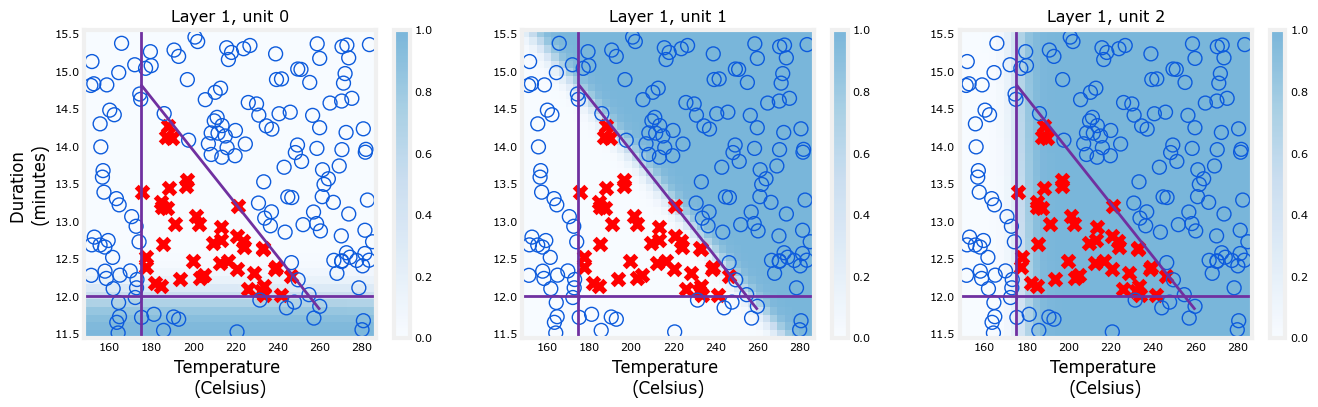

In [93]:
plt_layer(X,Y.reshape(-1,),W1,b1,normalization_layer)

# Mere experience me, I can see that every layer-unit graph lears a diff region each time.

Mere experience me, I can see that every layer-unit graph learns a diff region each time I run code.
This is also the reason the weights for each layer as well as unit come different every time, but the final model
output is correct.


### 1st run
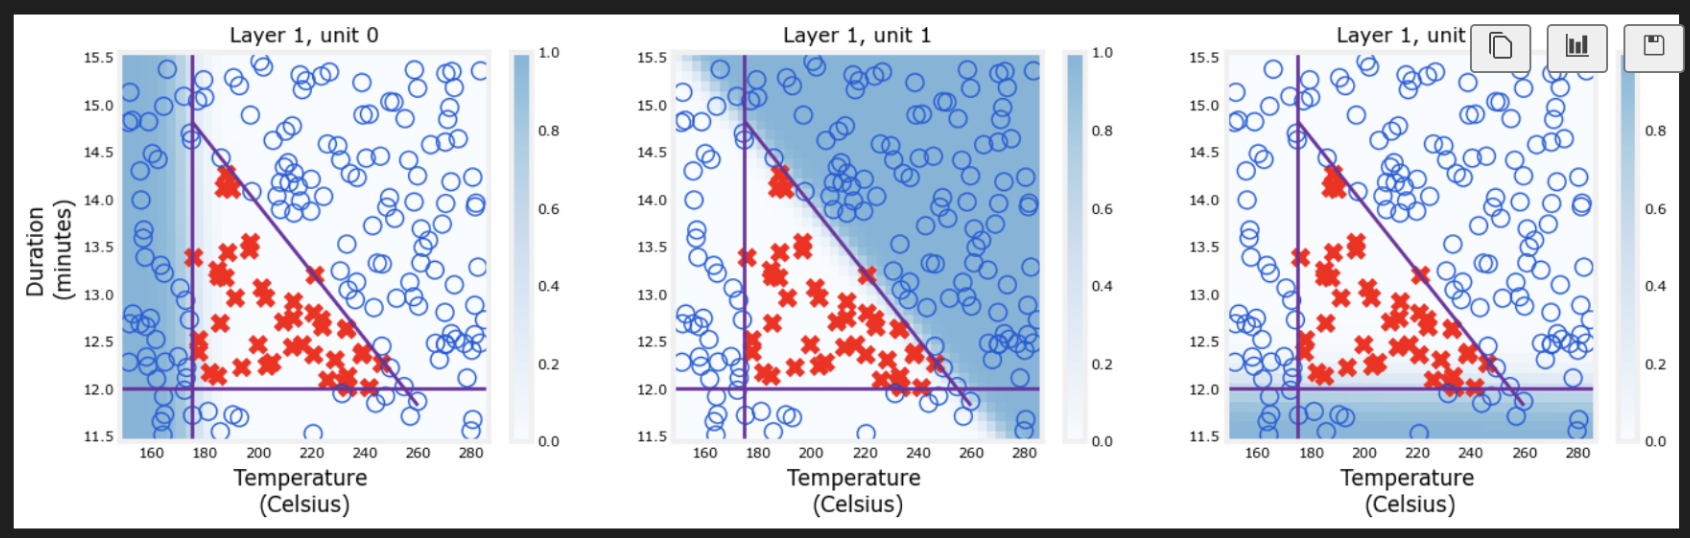

### 2nd run
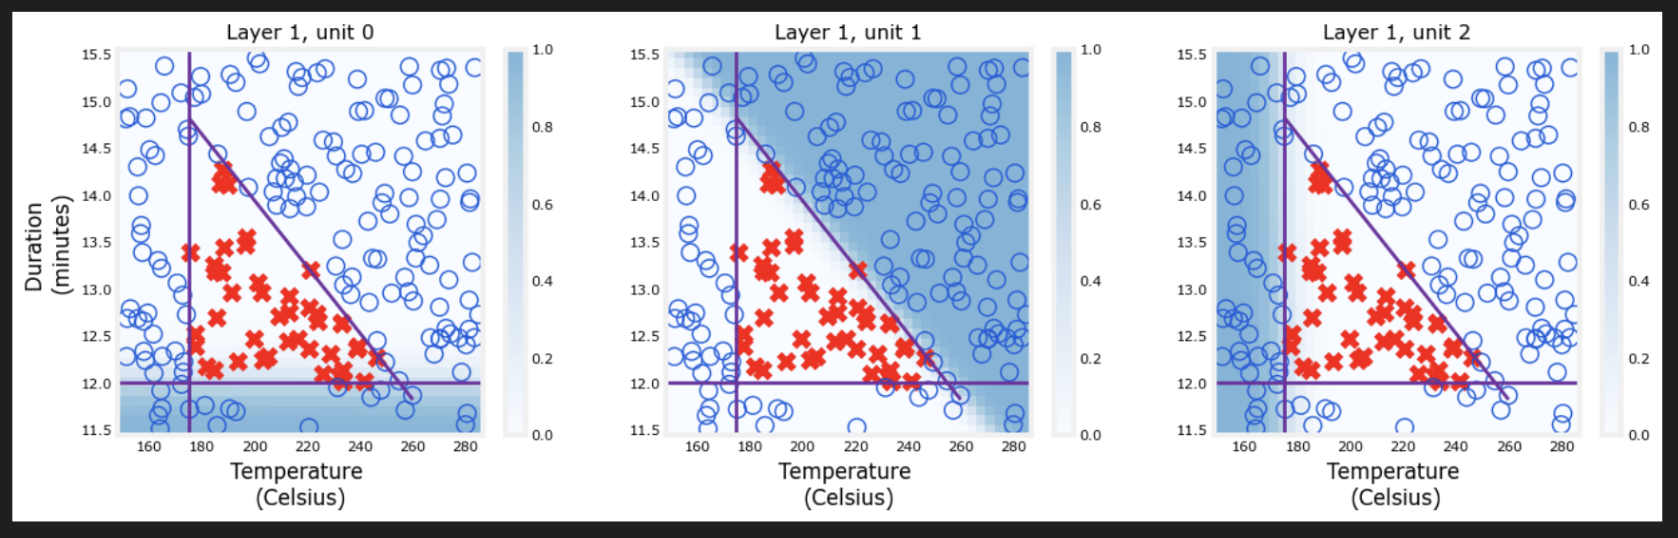

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

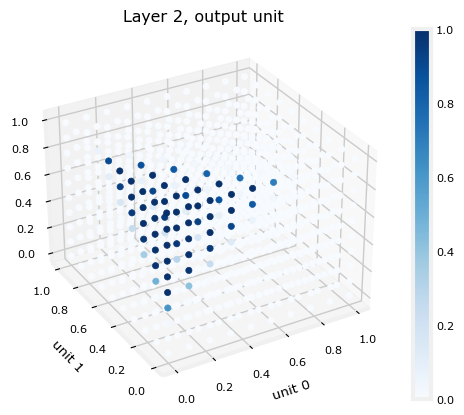

In [94]:
plt_output_unit(W2,b2)

The final graph shows the whole network in action.  
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  
The following takes a moment to run

7/7 [==============================] - 0s 418us/step


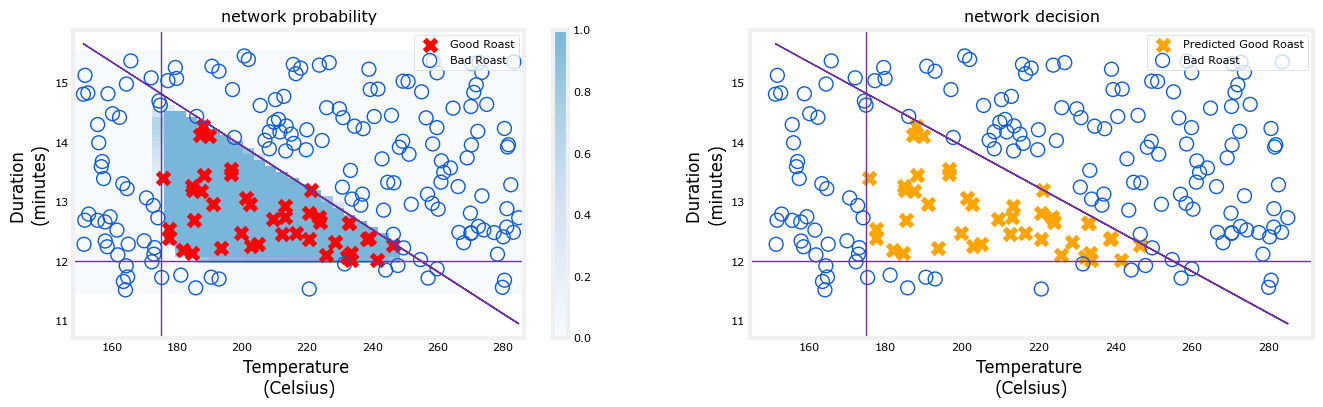

In [95]:
netf= lambda x : model.predict(normalization_layer(x))
plt_network(X,Y,netf)

# The netf= lambda x : model.predict(normalization_layer(x)) line defines a lambda function, 
# which is a small anonymous function that is defined with the lambda keyword. 
# This particular lambda function takes an input x, applies a normalization layer to it, 
# and then feeds the normalized input into a model to get a prediction. 
# The function is assigned to the variable netf.